In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as la

import seaborn as sn
import matplotlib.font_manager as fm

In [150]:
font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

sn.set_theme(context='notebook', style='whitegrid', palette='deep', font_scale=1, color_codes=True, rc=None)

In [151]:
# --- physical constants --- #

hbar = 0.658 # ev fs
m0 = 5.6856800 # fs{2} eV nm{-2}
veps0 = 5.52638e-2 # c{2} eV{-1} nm{-1}
n = 1.82
c0 = 299.792 # nm/fs
kb = 8.617e-5 # ev K {-1}

# --- system parameters --- #

Lwell = 0.636 # nm
A = Lwell**2 # nm{2}
Gamma0 = 0.0067 # eV
Msigma = 8 # fs ev nm{-1}
DAC = 1.9 # eV
DOP = 158 # ev nm{-1}
EgZero = 2.565 # eV

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

In [152]:
# --- import eigenvalues and eigenvectors calculated by solving the Wannier equation --- #

eigenvalues = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvalues5.txt')
eigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvectors5.txt')

In [153]:
def FFT(mu, eigenvectors): # inverse fourier transform of the amplitude of the wavefunctions

    C = A * dk / (2*np.pi)
    integral = np.sum(eigenvectors[mu][-500:] * k_vals)

    return (C * integral)**2

def RadiativeRecom(mu, eigenvalues, eigenvectors): # Temperature independent radiactive recombination of eletrons

    wavefunction = FFT(mu, eigenvectors)
    C = (hbar**2 * Msigma**2) / (2 * m0**2 * veps0 * A * n * c0)

    return C * wavefunction / eigenvalues[mu]

def ExcitonDephase(mu, temp): # Phenomenological non-radiative dephasing term

    A = RadiativeRecom(mu, eigenvalues, eigenvectors)
    B = 0.0067 / (np.exp(0.037/(kb*temp))-1)

    return A + B

In [154]:
def Absorption(energy_range, eigenvalues, eigenvectors, temp):

    alpha = []

    for E in energy_range:
        alphaMu = 0

        for mu in range(len(eigenvalues)):
            numerator = 2 * RadiativeRecom(mu, eigenvalues, eigenvectors) * ExcitonDephase(mu, temp)
            denominator = (eigenvalues[mu] - E)**2 + (ExcitonDephase(mu, temp) + RadiativeRecom(mu, eigenvalues, eigenvectors))**2
            alphaMu += numerator/denominator

        alpha.append(alphaMu)
        
    maxAlpha = max(alpha)

    return alpha


In [155]:
def FinalPlot(temps):

    E = np.linspace(-0.1, 0.2, 1000)
    data = {"Energy": E}
    
    for T in temps:
        data[f'{T}'] = Absorption(energy_range=E, eigenvalues=eigenvalues, eigenvectors=eigenvectors, temp=T)

    df = pd.DataFrame(data)

    mosaic = """ 
            AA
            BC
            
            """
    fig = plt.figure(layout='constrained', figsize=(6,6))
    ax_dict = fig.subplot_mosaic(mosaic, sharey=True, gridspec_kw={'hspace': 0})

    for column in df.columns[1:]:
        ax_dict["A"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["A"].set_xlim(-30, 200)
        ax_dict["A"].legend()

        ax_dict["B"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["B"].set_xlim(-30, 30)

        ax_dict["C"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["C"].set_xlim(100, 200)

        fig.supxlabel("$E - E_{1s}$ (meV)", fontsize=12)
        fig.supylabel("Absorption coefficient (arb. units)", fontsize=12)


        plt.savefig('absorptionNOT.pdf', dpi=600)


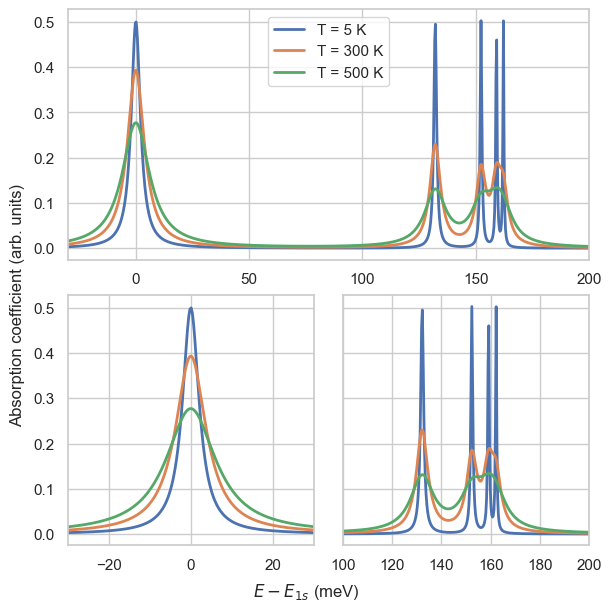

In [156]:
FinalPlot([5, 300, 500])

In [157]:
def FinalPlotVertical(temps):

    E = np.linspace(-0.1, 0.2, 1000)
    data = {"Energy": E}
    
    for T in temps:
        data[f'{T}'] = Absorption(energy_range=E, eigenvalues=eigenvalues, eigenvectors=eigenvectors, temp=T)

    df = pd.DataFrame(data)

    mosaic = """ 
            A
            B
            C
            """
    fig = plt.figure(layout='constrained', figsize=(5,10))
    ax_dict = fig.subplot_mosaic(mosaic, sharey=True)

    for column in df.columns[1:]:
        ax_dict["A"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["A"].set_xlim(-30, 200)

        ax_dict["B"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["B"].set_xlim(-30, 30)
        ax_dict["B"].legend()

        ax_dict["C"].plot((df['Energy'] - eigenvalues[0])*(-1000), df[column], label=f'T = {column} K', linewidth=2)
        ax_dict["C"].set_xlim(100, 200)

        fig.supxlabel("$E - E_{1s}$ (meV)", fontsize=12)
        fig.supylabel("Absorption coefficient (arb. units)", fontsize=12)
        fig.suptitle("E_step = 1000")

        plt.savefig('absorptionVertical1000.pdf', dpi=600)